In [1]:
import cPickle as cp

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import bivariate_normal

import autograd.numpy as np
from autograd import grad
%matplotlib inline

In [2]:
dim = 2
plot_x_lim = [-6, 6]
plot_y_lim = [-30, 10]
x = np.arange(plot_x_lim[0], plot_x_lim[1], 0.5)
y = np.arange(plot_y_lim[0], plot_y_lim[1], 0.5)
X, Y = np.meshgrid(x, y)

Let's define a function to perform AdaM updates...

In [3]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

### [Learning Model Reparametrizations](https://arxiv.org/abs/1708.01529)
#### By Michalis K. Titsias

The idea behind *Learning Model Reparametrizations* is to parametrize the variable of interest as a transformation of the form: $$ \boldsymbol{\theta} = g(\boldsymbol{\xi}; \boldsymbol{\phi}), \ \boldsymbol{\xi} \sim p_{0} $$ where $\boldsymbol{\theta}$ is the model variable, $\boldsymbol{\phi}$ are the transformation parameters, and $p_{0}$ is a fixed distribution.  MCMC is performed to collect $\boldsymbol{\xi}$ samples, which, ostensibly, is easier than collecting samples of $\boldsymbol{\theta}$ directly as we are aided by the transformation.  In order to compute the joint likelihood, the transformation must be invertible, enabling use of the change of variables formula: $$ p(\mathbf{x}, \boldsymbol{\xi}; \boldsymbol{\phi}) = p(\mathbf{x}, g(\boldsymbol{\xi}; \boldsymbol{\phi})) \ \mid \text{det} \ \nabla_{\boldsymbol{\xi}} \  g(\boldsymbol{\xi}; \boldsymbol{\phi}) \mid $$ where $\mid \text{det} \ \nabla_{\boldsymbol{\xi}} \  g(\boldsymbol{\xi}; \boldsymbol{\phi}) \mid$ is the transformation's Jacobian.  Inference proceeds by running MCMC on $p(\mathbf{x}, \boldsymbol{\xi}; \boldsymbol{\phi})$ twice per iteration.  The first set of $\boldsymbol{\xi}$ samples are used for a gradient-based update of the transformation parameters $\boldsymbol{\phi}$, and the second set are used to update point estimates for any remaining model parameters.

### Experiment: Collecting samples from the banana distribution
Let's draw data from the classic MCMC test case: the banana distribution...

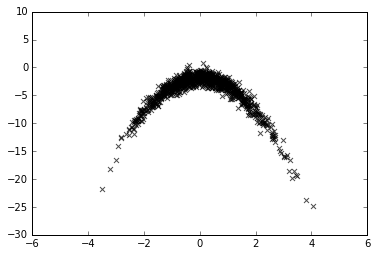

In [4]:
### Make Dataset
N = 1000
data = np.random.normal(size=(N, dim))
z1 = 1.25*data[:,0]
z2 = data[:,1]/1.25 - 1.5*(z1**2 + 1.25)
data = np.hstack([z1[np.newaxis].T, z2[np.newaxis].T])
np.random.shuffle(data)

plt.scatter(data[:,0], data[:,1], marker='x', s=25, c='k', alpha=.7)

plt.xlim([plot_x_lim[0], plot_x_lim[1]])
plt.ylim([plot_y_lim[0], plot_y_lim[1]])
plt.show()

### Method

First, let's define the models.  We'll use an uncorrelated Gaussian for all models, including the MCMC proposal.  We assume the (banana) data is drawn from $ \boldsymbol{x} \sim \text{N}(\boldsymbol{\theta}, \text{diag}(\boldsymbol{\Sigma})) $ and the mean is generated by the transformation $\boldsymbol{\theta} = \boldsymbol{\mu} + \boldsymbol{\xi} \mathbf{L}$ where $\mathbf{L}$ is a positive, lower-triangular matrix.  Thus, we'll update $\{\boldsymbol{\mu}, \mathbf{L} \}$ with the first set of MCMC draws and $\{\boldsymbol{\Sigma}\}$ with the second.

In [5]:
# Gaussian
def logGaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return  -.5/params['sigma']**2 * (x-params['mu'])**2 + -.5 * np.log(2*np.pi*params['sigma']**2)

# Gaussian model
def logModel(data, theta, logSigma):
    return np.sum(logGaussPdf(data, {'mu':theta, 'sigma': np.exp(logSigma)}))

# Gaussian model with lower triangular inv transform
def logModel_w_transform(data, mu, logL, e, logSigma):
    L = np.exp(logL)
    theta = mu + np.dot(e, L)
    return logModel(data, theta, logSigma) + np.sum(np.log(np.diag(L)))

Next let's get functions for the necessary gradients: $\partial \log p(\mathbf{x}, \boldsymbol{\xi}; \boldsymbol{\phi}) / \partial \boldsymbol{\mu}$, $\partial \log p(\mathbf{x}, \boldsymbol{\xi}; \boldsymbol{\phi}) / \partial \mathbf{L}$, and $\partial \log p(\mathbf{x}, \boldsymbol{\theta}) / \partial \boldsymbol{\Sigma}$...

In [6]:
dLogModelWithTransform_dMu = grad(lambda mu, data, logL, e, logSigma: logModel_w_transform(data, mu, logL, e, logSigma))

dLogModelWithTransform_dLogL = grad(lambda logL, data, mu, e, logSigma: logModel_w_transform(data, mu, logL, e, logSigma))

dLogModel_dLogSigma = grad(lambda logSigma, data, theta: logModel(data, theta, logSigma))

Now let's define a function to run MCMC on $p(\mathbf{x}, \hat{\boldsymbol{\xi}}; \boldsymbol{\phi}) / p(\mathbf{x}, \boldsymbol{\xi}_{0}; \boldsymbol{\phi})$ with the proposal $\hat{\boldsymbol{\xi}} \sim \text{N}(\mathbf{0},\mathbb{I})$...

In [7]:
def run_MH(data, logModel_w_transform, model_params, reparam_params, e0, n_MCMC_its):
    samples = []
    
    for idx in range(n_MCMC_its):
        proposal = np.random.normal(loc=e0, scale=1, size=(1,2))
        
        log_ratio = logModel_w_transform(data, reparam_params['mu'], reparam_params['logL'], proposal, model_params['logSigma']) \
                - logModel_w_transform(data, reparam_params['mu'], reparam_params['logL'], e0, model_params['logSigma'])
        log_correction = np.sum(logGaussPdf(e0, {'mu':proposal, 'sigma':1.})) - np.sum(logGaussPdf(proposal, {'mu':e0, 'sigma':1.}))
        
        accept_prob = np.minimum(1., np.exp(log_ratio + log_correction))
        uni_prob = np.random.uniform(low=0., high=1.)
        
        if uni_prob <= accept_prob:
            samples.append(proposal)
            e0 = proposal
            
    return samples

Putting everything together for Algorithm \#1 (page 6), using AdaM for the gradient updates...

In [8]:
def run_implicitMCMC_VI(data, model_params, reparam_params, lr=.001, n_epochs=100, nChains=20, n_MCMC_its=100):
    
    adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
                    'logL':{'mean': 0., 'var': 0., 't': 0},
                    'logSigma':{'mean': 0., 'var': 0., 't': 0},
                   }
    
    for it_idx in range(n_epochs):
        
        # update the reparametrization parameters
        e_samples = []
        for s in range(nChains):
            e0 = np.array([[np.random.normal(scale=np.sqrt(2)), np.random.normal(loc=-25, scale=np.sqrt(3))]])
            e_samples.append(run_MH(data, logModel_w_transform, model_params, reparam_params, e0, n_MCMC_its)[-1])
        
        grad_mu = 0.
        grad_logL = 0.
        for e in e_samples:
            grad_mu += dLogModelWithTransform_dMu(reparam_params['mu'], data, reparam_params['logL'], e, model_params['logSigma']) / nChains
            grad_logL += dLogModelWithTransform_dLogL(reparam_params['logL'], data, reparam_params['mu'], e, model_params['logSigma']) / nChains
        
        reparam_params['mu'] += get_AdaM_update(lr, grad_mu/len(e_samples), adam_values['mu']) 
        reparam_params['logL'] += np.tril( get_AdaM_update(lr, grad_logL, adam_values['logL']) )
        
        # update model params
        thetas = []
        for s in range(nChains):
            e0 = np.array([[np.random.normal(scale=np.sqrt(2)), np.random.normal(loc=-25, scale=np.sqrt(3))]])
            e_samples = run_MH(data, logModel_w_transform, model_params, reparam_params, e0, n_MCMC_its)
            thetas.append( reparam_params['mu'] + np.dot(e_samples[-1], np.exp(reparam_params['logL'])) )
        
        grad_logSig = 0.
        for theta in thetas:
            grad_logSig += dLogModel_dLogSigma(model_params['logSigma'], data, theta) / nChains
        
        model_params['logSigma'] += get_AdaM_update(lr, grad_logSig, adam_values['logSigma'])
        
        # check data likelihood
        print "Epoch #%d, LL: %.4f" %(it_idx+1, np.mean([logModel(data, theta, model_params['logSigma']) for theta in thetas]))

    # get one more round of samples
    final_e_samples = []
    for s in range(500):
        e0 = np.array([[np.random.normal(scale=2), np.random.normal(loc=-20, scale=3)]])
        final_e_samples.append(run_MH(data, logModel_w_transform, model_params, reparam_params, e0, n_MCMC_its)[-1])
    
    return model_params, reparam_params, final_e_samples

Finally, let's run the algorithm...

In [9]:
# INIT PARAMS
model_params = {'logSigma': np.zeros((1,2))}
reparam_params = {'logL': np.eye(2)*.01, 'mu': np.zeros((1,2))}


maxEpochs = 100
learning_rate = .03
nChains = 50
nMCMCSteps = 50

model_params, reparam_params, final_e_samples = run_implicitMCMC_VI(data, model_params, reparam_params, \
                                                                    lr=learning_rate, n_epochs=maxEpochs,\
                                                                    nChains=nChains, n_MCMC_its=nMCMCSteps)

final_theta_samples = [reparam_params['mu'] + np.dot(e, np.exp(reparam_params['logL'])) for e in final_e_samples]

x_samples = []
for theta in final_theta_samples:
    for s in range(1):
        x_samples.append( theta + np.random.normal(size=(1,2))*np.exp(model_params['logSigma']) ) 

final_theta_samples = np.array(final_theta_samples)[:,0,:]
x_samples = np.array(x_samples)[:,0,:]

//anaconda/lib/python2.7/site-packages/autograd/core.py:107: RuntimeWarning: overflow encountered in exp
  result = self.fun(*argvals, **kwargs)


Epoch #1, LL: -12476.0637
Epoch #2, LL: -10437.7788
Epoch #3, LL: -8243.2878
Epoch #4, LL: -10857.8806
Epoch #5, LL: -10976.7924
Epoch #6, LL: -8293.6888
Epoch #7, LL: -9246.9025
Epoch #8, LL: -8597.0608
Epoch #9, LL: -7667.9247
Epoch #10, LL: -9230.3749
Epoch #11, LL: -6996.1686
Epoch #12, LL: -7052.6903
Epoch #13, LL: -8462.0853
Epoch #14, LL: -6862.9980
Epoch #15, LL: -6232.2872
Epoch #16, LL: -5396.6238
Epoch #17, LL: -5355.2514
Epoch #18, LL: -5578.6765
Epoch #19, LL: -5110.3600
Epoch #20, LL: -5011.2599
Epoch #21, LL: -4936.6214
Epoch #22, LL: -5242.1282
Epoch #23, LL: -4912.0836
Epoch #24, LL: -4810.5175
Epoch #25, LL: -4869.1668
Epoch #26, LL: -5114.1281
Epoch #27, LL: -5432.7441
Epoch #28, LL: -4988.2317
Epoch #29, LL: -4936.8994
Epoch #30, LL: -4870.7518
Epoch #31, LL: -4792.9861
Epoch #32, LL: -4723.3535
Epoch #33, LL: -4728.2715
Epoch #34, LL: -4717.2676
Epoch #35, LL: -4644.1239
Epoch #36, LL: -4612.9810
Epoch #37, LL: -4637.1946
Epoch #38, LL: -4724.1898
Epoch #39, LL: -4

And visualize the results, including the initial $\boldsymbol{\xi}$ density (blue)...

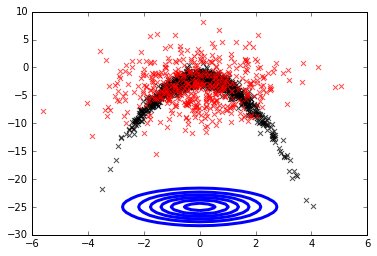

In [10]:
Z = bivariate_normal(X, Y, sigmax=np.sqrt(2), sigmay=np.sqrt(3), mux=0, muy=-25)
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.scatter(data[:,0], data[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(x_samples[:,0], x_samples[:,1], marker='x', s=25, c='r', alpha=.7)

plt.xlim([plot_x_lim[0], plot_x_lim[1]])
plt.ylim([plot_y_lim[0], plot_y_lim[1]])
plt.show()